In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

In [8]:
# Define paths
original_dir = "./dataset"
train_dir = os.path.join(original_dir, 'train_val')
test_dir = os.path.join(original_dir, 'test')

# Image parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20

In [9]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of train_val for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3799 images belonging to 4 classes.
Found 948 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.


In [11]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.3188 - loss: 1.4460 - val_accuracy: 0.4525 - val_loss: 1.2565
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.4368 - loss: 1.2353 - val_accuracy: 0.4357 - val_loss: 1.2091
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.4730 - loss: 1.1986 - val_accuracy: 0.4800 - val_loss: 1.1830
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.4594 - loss: 1.1843 - val_accuracy: 0.4852 - val_loss: 1.1823
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.4736 - loss: 1.1817 - val_accuracy: 0.4768 - val_loss: 1.1819
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.4773 - loss: 1.1637 - val_accuracy: 0.4947 - val_loss: 1.1935
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.4811 - loss: 1.1785 - val_accuracy: 0.5390 - val_loss: 1.1504
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.4771 - loss: 1.1690 - val_accu

In [13]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5551 - loss: 0.9594
Test accuracy: 0.5755


38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step


<Figure size 1000x800 with 0 Axes>

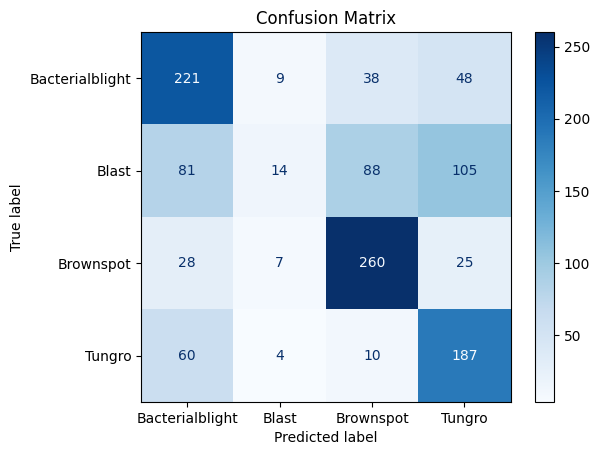

In [14]:
# Generate confusion matrix
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

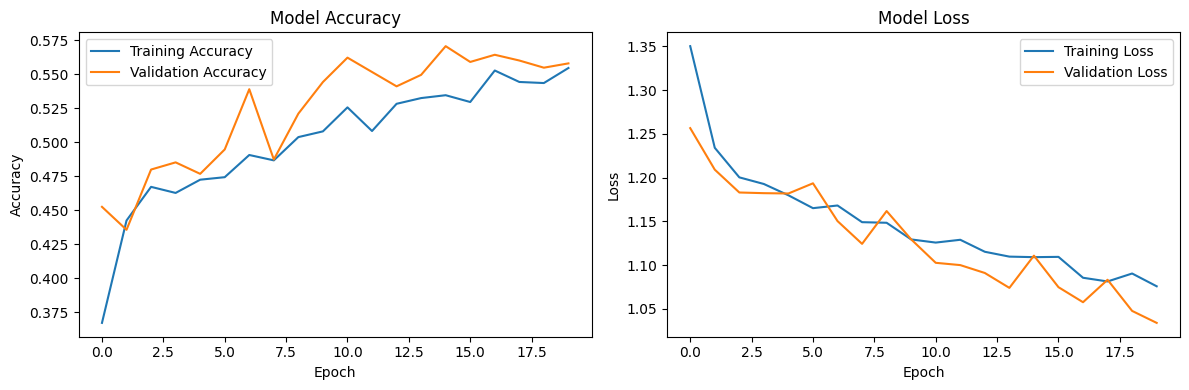

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


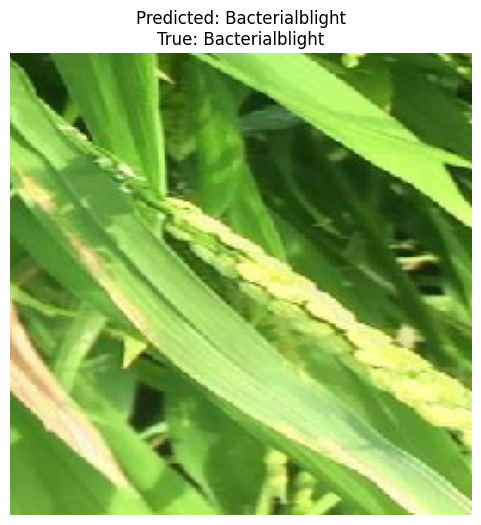

Image path: ./dataset\test\Bacterialblight\BACTERIALBLIGHT2_077.jpg
Predicted class: Bacterialblight
True class: Bacterialblight


In [16]:
# Test a random image from test directory
def test_random_image(test_dir, model, class_labels):
    # Get list of all images in test directory
    all_images = []
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    all_images.append(os.path.join(class_path, img_name))
    
    if not all_images:
        print("No images found in test directory!")
        return
    
    # Select random image
    random_img_path = random.choice(all_images)
    
    # Load and preprocess image
    img = load_img(random_img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    
    # Display image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nTrue: {os.path.basename(os.path.dirname(random_img_path))}")
    plt.axis('off')
    plt.show()
    print(f"Image path: {random_img_path}")
    print(f"Predicted class: {predicted_class}")
    print(f"True class: {os.path.basename(os.path.dirname(random_img_path))}")

# Run random image test
test_random_image(test_dir, model, class_labels)

In [17]:
# Save the model
model.save('rice_leaf_resnet.h5')